In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import yaml
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

In [2]:
data_id = "12"

with open(f'my_data{data_id}.yaml') as f:
    data = yaml.safe_load(f)

ERROR
skipped concurrency 1
ERROR
skipped concurrency 2


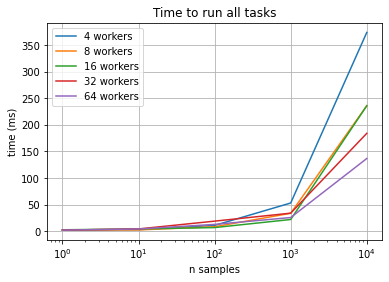

In [3]:
# TOTAL WF TIME
# OVERHEAD TYPE 2
    
concurrencies = [1,2,4,8,16,32,64]
samples = [1,10,100,1000,10000]
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data.items():
        if f"c{con}_" in name and "start verify" in name:
            if "ERROR" in str(val):
                print("ERROR")
                break
            start_verify = val
        if f"c{con}_" in name and "start run-workers" in name:
            start_run_workers = val
            all_task_times.append((start_verify - start_run_workers))
        
    try:
        ax.plot(samples, all_task_times, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue
        
plt.xscale("log")
ax.legend()

ax.set(xlabel='n samples', ylabel='time (ms)',
               title='Time to run all tasks')
ax.grid()

#fig.savefig(f"figs/all_task_time__{data_id}.png")
plt.show()

skipped concurrency 1


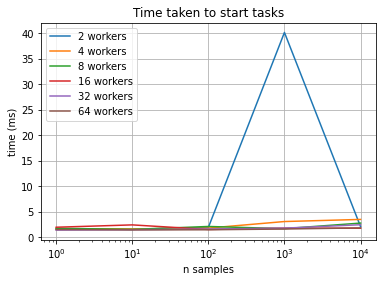

In [4]:
# TIME TO START WORKING ON TASKS
# OVERHEAD TYPE 4
    
concurrencies = [1,2,4,8,16,32,64]
samples = [1,10,100,1000,10000]
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data.items():
        if f"c{con}_" in name and "start run-workers" in name:
            start_run_workers = val
        if f"c{con}_" in name and "start samp1" in name:
            if "ERROR" in str(val):
                print("ERROR")
                break
            start_samp1 = val
            all_task_times.append((start_samp1 - start_run_workers))
        
    try:
        ax.plot(samples, all_task_times, label=f"{con} workers")
    except ValueError as e:
        print(f"skipped concurrency {con}")
        continue
        
plt.xscale("log")
ax.legend()

ax.set(xlabel='n samples', ylabel='time (ms)',
               title='Time taken to start tasks')
ax.grid()

#fig.savefig(f"figs/task_start_time__{data_id}.png")
plt.show()

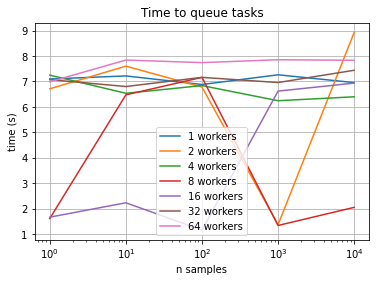

In [5]:
# TIME TO QUEUE ALL TASKS
# OVERHEAD TYPE 3
    
concurrencies = [1,2,4,8,16,32,64]
samples = [1,10,100,1000,10000]
fig, ax = plt.subplots()

for con in concurrencies:
    all_task_times = []
    for name, val in data.items():
        #print(name)
        if f"c{con}_" in name and "merlin run" in name:
            queue_tasks = val
            all_task_times.append(queue_tasks)
        
    ax.plot(samples, all_task_times, label=f"{con} workers")
        
plt.xscale("log")
ax.legend()

ax.set(xlabel='n samples', ylabel='time (s)',
               title='Time to queue tasks')
ax.grid()

#fig.savefig(f"figs/task_queue_time__{data_id}.png")
plt.show()

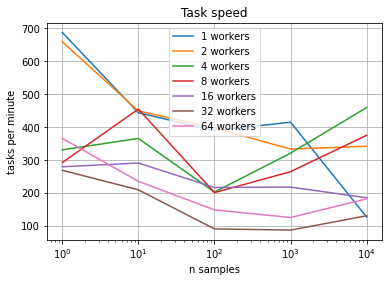

In [6]:
# TASK SPEED
# OVERHEAD TYPE 1
    
concurrencies = [1,2,4,8,16,32,64]
samples = [1,10,100,1000,10000]
fig, ax = plt.subplots()

for con in concurrencies:
    t_per_m = []
    for name, times in data.items():
        if f"c{con}_" in name and " " not in name:
            n_tasks = len(times)
            seconds = sum(times)
            mins = seconds / 60.0
            tasks_per_min = n_tasks / mins
            t_per_m.append(tasks_per_min)
    ax.plot(samples, t_per_m, label=f"{con} workers")

plt.xscale("log")
ax.legend()

ax.set(xlabel='n samples', ylabel='tasks per minute',
               title='Task speed')
ax.grid()

#fig.savefig(f"figs/task_speed__{data_id}.png")
plt.show()

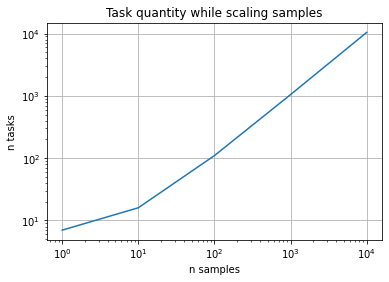

In [7]:
concurrency = 16

n_tasks = []
for sam in samples:
    for name, times in data.items():
        if name.endswith(f"_s{sam}") and name.startswith(f"c16_"):
            n_tasks.append(len(times))
            
fig, ax = plt.subplots()
ax.plot(samples, n_tasks)
plt.xscale("log")
plt.yscale("log")
ax.set(xlabel='n samples', ylabel='n tasks',
       title='Task quantity while scaling samples')
ax.grid()

#fig.savefig(f"figs/n_tasks3__{data_id}.png")
plt.show()

WITH OUTLIERS
68008 task times
17.961137083359063: max task time
0.2782271668423009: mean task time
1.2568207067754011: standard deviation

WITHOUT OUTLIERS
4759 task times
63249 task times
0.16254653315991163: max task time
0.06811255348810123: mean task time
0.027937617671493154: standard deviation


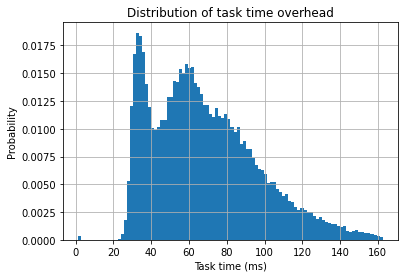

In [8]:
# OVERHEAD TYPE 1
# combining data from all concurrencies and sample quantities

def is_outlier(points, thresh=3):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

x = []
fig, ax = plt.subplots()

for name, times in data.items():
    if " " not in name:
        x += times

x = np.array(x)
#mad = stats.median_absolute_deviation(x)
outlier_mask = is_outlier(x)

print("WITH OUTLIERS")
print(f"{len(x)} task times")
print(f"{max(x)}: max task time")
print(f"{np.mean(x)}: mean task time")
print(f"{np.std(x)}: standard deviation")
outliers = x[outlier_mask]
non_outliers = x[~outlier_mask]
print("\nWITHOUT OUTLIERS")
print(f"{len(outliers)} task times")
print(f"{len(non_outliers)} task times")
print(f"{max(non_outliers)}: max task time")
print(f"{np.mean(non_outliers)}: mean task time")
print(f"{np.std(non_outliers)}: standard deviation")

n_bins = 100

ax.grid()
plt.hist(non_outliers*1000, bins=n_bins, density=True)
plt.xlabel('Task time (ms)')
plt.ylabel('Probability')
ax.set(title='Distribution of task time overhead')
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#plt.savefig(f"figs/histogram__{data_id}.png")

plt.show()